# HW3
## Image Captioning with Conditioned LSTM Generators



Student names:<br>
Moukthika Dasika   
Venkata Sai Nitesh Adapa<br> 
Vyshnav Raj Shivashetty<br>
Teja Vardhan Reddy Janga<br>
Jai Venkata Sai Sriram Batchu

Student IDs:<br>
1002025915<br>
1002004212<br>
1002035282<br>
1002031742<br>
1001949158


Follow the instructions in this notebook step-by step. Much of the code is provided, but some sections are marked with **TODO**. 

Specifically, you will build the following components: 

* Create matrices of image representations using an off-the-shelf image encoder.
* Read and preprocess the image captions. 
* Write a generator function that returns one training instance (input/output sequence pair) at a time. 
* Train an LSTM language generator on the caption data.
* Write a decoder function for the language generator. 
* Add the image input to write an LSTM caption generator. 
* Beam search to refine output captions.

Each group please submit one copy of this notebook only, including all outputs. 

Reference:
https://medium.com/@raman.shinde15/image-captioning-with-flickr8k-dataset-bleu-4bcba0b52926#:~:text=Captions%20are%20read%20from%20Flickr8k.token.txt%20file%20and%20stored,format%20%E2%80%9Cstartseq%20%E2%80%9C%20%2B%20caption%20%2B%20%E2%80%9C%20endseq%E2%80%9D

### Getting Started 

First, run the following commands to make sure you have all required packages. 

In [53]:
# tested with python 3.6
import os
import random
import itertools
from collections import defaultdict
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
#The below 2 lines should only be run once.
#!pip install tensorflow==2.7.0
#!pip install keras_nlp
from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from keras.activations import softmax
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import keras_nlp
import tensorflow as tf
from tensorflow import keras
from keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.optimizers import Adam

from google.colab import drive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 142 kB 5.1 MB/s 
     |████████████████████████████████| 5.9 MB 41.1 MB/s 
     |████████████████████████████████| 578.0 MB 15 kB/s 
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 4.6 MB 54.7 MB/s 
     |████████████████████████████████| 511.8 MB 9.8 kB/s 
     |████████████████████████████████| 511.7 MB 6.4 kB/s 
     |████████████████████████████████| 511.7 MB 4.7 kB/s 
     |████████████████████████████████| 4.9 MB 54.5 MB/s 
     |████████████████████████████████| 497.9 MB 37 kB/s 
     |████████████████████████████████| 437.8 MB 44 kB/s 
     |████████████████████████████████| 437.8 MB 25 kB/s 
     |████████████████████████████████| 518.1 MB 30 kB/s 
     |████████████████████████████████| 518.1 MB 20

### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail: 

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html

Dataset: https://www.kaggle.com/datasets/adityajn105/flickr8k

You need to download the dataset and then upload it again to your own drive. Please assign the name you choose for this folder to the variable `my_data_dir` in the next cell.


In [2]:
#this is where you put the name of your data folder.
#Please make sure it's correct because it'll be used in many places later.
my_data_dir="hw3_data"

### Mounting your GDrive so you can access the files from Colab (optional)

In [3]:
#running this command will generate a message that will ask you to click on a link where you'll obtain your GDrive auth code.
#copy paste that code in the text box that will appear below
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Please look at the 'Files' tab on the left side and make sure you can see the 'hw5_data' folder that you have in your GDrive.

## Part I: Understand the data (10 pts)

> Indented block



Read the caption file:

In [4]:
df = pd.read_csv(f'/content/gdrive/MyDrive/hw3_data/captions.txt')
print(df.shape)
df.head()

(40455, 2)


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Train, test split:

In [5]:
# TODO: train, test split: 0.8: 0.2
X, y = df["image"], df["caption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Each entry is an image filename.

In [6]:
X_train.head()

32121     359082432_c1fd5aa2d6.jpg
9831     2460799229_ce45a1d940.jpg
33128    3634828052_3b6aeda7d6.jpg
6199     2216568822_84c295c3b0.jpg
19661    3080056515_3013830309.jpg
Name: image, dtype: object

Check an example:

In [ ]:
example_file = df.iloc[9]['image']
cap = df.iloc[9]['caption']
image = Image.open(os.path.join('/content/gdrive/MyDrive/hw3_data/Images', example_file))
print(image.size)
print(cap)

(500, 375)
Two dogs on pavement moving toward each other .


If you can't see the image, try

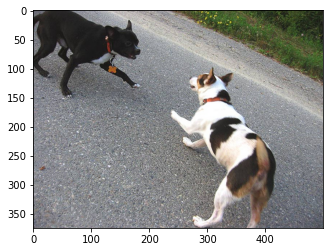

In [ ]:
plt.imshow(image)

## Part II: Image encoder (10 pts)
We are going to use an off-the-shelf pre-trained image encoder, the Inception V3 network. The model is a version of a convolution neural network for object detection. Here is more detail about this model (not required for this project): 

> Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
> https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html

The model requires that input images are presented as 299x299 pixels, with 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0. The flickr images don't fit. 

In [ ]:
np.asarray(image).shape

(375, 500, 3)

The values range from 0 to 255. 

In [ ]:
np.asarray(image)

array([[[102, 103, 108],
        [ 95,  96, 101],
        [ 99, 100, 105],
        ...,
        [ 29,  29,  21],
        [ 31,  28,  23],
        [ 30,  25,  22]],

       [[108, 109, 114],
        [100, 101, 106],
        [ 94,  95, 100],
        ...,
        [ 37,  37,  29],
        [ 37,  34,  29],
        [ 33,  28,  25]],

       [[112, 112, 120],
        [118, 118, 126],
        [100, 100, 108],
        ...,
        [ 40,  40,  32],
        [ 37,  34,  29],
        [ 34,  31,  26]],

       ...,

       [[103, 101, 114],
        [104,  98, 110],
        [122, 114, 127],
        ...,
        [ 83,  88,  94],
        [ 76,  83,  89],
        [ 72,  79,  85]],

       [[111, 114, 121],
        [ 91,  88,  97],
        [ 85,  78,  86],
        ...,
        [ 95, 100, 106],
        [ 79,  84,  90],
        [ 79,  84,  90]],

       [[ 93,  96, 101],
        [ 69,  66,  73],
        [111, 101, 109],
        ...,
        [ 88,  91,  98],
        [ 82,  85,  92],
        [ 94,  99, 105]]

We can use PIL to resize the image and then divide every value by 255. 

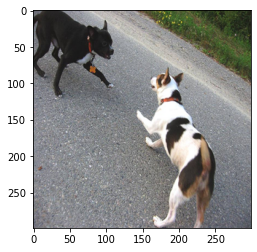

In [ ]:
new_image = np.asarray(image.resize((299,299))) / 255.0
plt.imshow(new_image)

In [ ]:
new_image.shape

(299, 299, 3)

Let's put this all in a function for convenience. 

In [40]:
def read_image(image_name):
    image = Image.open(os.path.join('/content/gdrive/MyDrive/hw3_data/Images', image_name))
    return np.asarray(image.resize((299,299))) / 255.0                     

Next, we load the pre-trained Inception model. 

In [ ]:
img_model = InceptionV3(weights='imagenet') # This will download the weight files for you and might take a while.

96112376/96112376 [==============================] - 1s 0us/step


In [ ]:
img_model.summary() # this is quite a complex model. 

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

This is a prediction model,so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 2048. 

We will use the following hack: hook up the input into a new Keras model and use the penultimate layer of the existing model as output.

In [ ]:
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output) # This is the final Keras image encoder model we will use.

Let's try the encoder. 

In [ ]:
encoded_image = img_encoder.predict(np.array([new_image]))

1/1 [==============================] - 3s 3s/step


In [ ]:
encoded_image.shape

(1, 2048)

**TODO:** We will need to create encodings for all images and store them in one big matrix (one for each dataset, train, test).
We can then save the matrices so that we never have to touch the bulky image data again. 

To save memory (but slow the process down a little bit) we will read in the images lazily using a generator. We will encounter generators again later when we train the LSTM. If you are unfamiliar with generators, take a look at this page: https://wiki.python.org/moin/Generators

Write the following generator function, which should return one image at a time. 
`img_list` is a list of image file names (i.e. the train, dev, or test set). The return value should be a numpy array of shape (1,299,299,3).

Now we can encode all images (this takes a few minutes).

In [ ]:
def img_generator(img_list):
    for k in img_list:
      yield read_image(k).reshape(1,299,299,3)

In [ ]:
enc_train = img_encoder.predict(img_generator(X_train), steps=len(X_train), verbose=1)

32364/32364 [==============================] - 9088s 281ms/step


In [ ]:
enc_train.shape

(32364, 2048)

In [ ]:

enc_test = img_encoder.predict(img_generator(X_test), steps=len(X_test), verbose=1)

8091/8091 [==============================] - 2138s 264ms/step


It's a good idea to save the resulting matrices, so we do not have to run the encoder again. 

In [ ]:
np.save(f"/content/gdrive/MyDrive/hw3_data/encoded_images_train.npy", enc_train)
np.save(f"/content/gdrive/MyDrive/hw3_data/encoded_images_test.npy", enc_test)

## Part III Text (Caption) Data Preparation (10 pts)

Next, we need to load the image captions and generate training data for the generator model.

### Reading image descriptions

**TODO**: Write the following function that reads the image descriptions from the file `filename` and returns a dictionary in the following format. Take a look at the file `Flickr8k.token.txt` for the format of the input file. Data from https://github.com/text-machine-lab/MUTT/tree/master/data/flickr

The keys of the dictionary should be image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so you can just split them at white spaces. You should convert each token to lower case. You should then pad each caption with a START token on the left and an END token on the right. 

In [7]:
def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list)
    # TODO: here
    with open(filename) as f:
      for line in f:
        line = line.split("\t")
        if line[0][:-2] not in image_descriptions:
          image_descriptions[line[0][:-2]] = [['<START>'] + line[1][:-1].lower().split(" ") + ['<END>']]
        else:
          image_descriptions[line[0][:-2]].append(['<START>'] + line[1][:-1].lower().split(" ") + ['<END>'])


    
    return image_descriptions

In [8]:
# Populating description dictionary using the above method
descriptions = read_image_descriptions(f"/content/gdrive/MyDrive/hw3_data/Flickr8k.token.txt")

In [9]:
print(descriptions[X_train[0]])


[['<START>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<END>'], ['<START>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '<END>']]


Running the previous cell should print similar to this:     
`[['<START>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<END>'], ['<START>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '<END>']]
`    

### Creating Word Indices

Next, we need to create a lookup table from the **training** data mapping words to integer indices, so we can encode input 
and output sequences using numeric representations. **TODO** create the dictionaries id_to_word and word_to_id, which should map tokens to numeric ids and numeric ids to tokens.  
Hint: Create a set of tokens in the training data first, then convert the set into a list and sort it. This way if you run the code multiple times, you will always get the same dictionaries. 

In [10]:
# TODO: 
# Creating the unique words list, using the set and list sort method
l = []
for i in X_train:
  d = descriptions[i]
  for j in d:
    l.extend(j)
l = set(l)
l = list(l)
l.sort()
print(l)

['!', '"', '#', '&', "'", "'n'", "'s", "'s-eye-view", "'slide", '(', ')', ',', '-', '-ependent', '.', '08', '1', '10', '104', '11', '12', '13', '13406', '157', '17', '19', '1915', '1923', '1950s', '2', '2008', '21', '22', '23', '25', '28', '281', '29', '3', '3-wheeler', '30', '32', '33', '3rd', '4', '4-wheel', '4-wheeler', '42', '4x4', '5', '50', '52', '528', '57', '58', '6', '625', '661', '7', '75', '8', '80', '84', '90', '93', '97', ':', ';', '<END>', '<START>', '?', 'a', 'a-frame', 'abandon', 'abandoned', 'abarrotes', 'abdomen', 'ability', 'aboard', 'aboriginal', 'about', 'above', 'above-ground', 'abs', 'abseiling', 'ac', 'accelerates', 'accends', 'accent', 'accented', 'accents', 'accepting', 'accepts', 'accessories', 'accident', 'accompanied', 'accompanies', 'accompanying', 'accordion', 'accross', 'ace', 'acoustic', 'acrobat', 'acrobatic', 'acrobatics', 'acroos', 'across', 'acrouss', 'act', 'acting', 'action', 'actions', 'active', 'activities', 'activity', 'actor', 'actors', 'acts'

In [ ]:
# TODO: 
# id_to_word = #...
# word_to_id = #...


In [11]:
id_to_word = {}
word_to_id = {}
id_to_word[0] = None
for i in range(len(l)):
  id_to_word[i + 1] = l[i]
for i in id_to_word.keys():
  word_to_id[id_to_word[i]] = i

In [12]:
word_to_id['dog'] # should print an integer

2309

In [13]:
id_to_word[2309] # should print a token

'dog'

In [14]:
len(word_to_id)

8920

In [15]:
len(id_to_word)

8920

Note that we do not need an UNK word token because we are generating. The generated text will only contain tokens seen at training time.  

## Part IV Basic Decoder Model (20 pts)

For now, we will just train a model for text generation without conditioning the generator on the image input. 

There are different ways to do this and our approach will be slightly different from the generator discussed in class. 

The core idea here is that the Keras recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different unit, but the weights for these units are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [16]:
max(len(description) for image_id in X_train for description in descriptions[image_id])

40

In class, we discussed LSTM generators as transducers that map each word in the input sequence to the next word. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm1.png" width="480px">

Instead, we will use the model to predict one word at a time, given a partial sequence. For example, given the sequence ["START","a"], the model might predict "dog" as the most likely word. We are basically using the LSTM to encode the input sequence up to this point. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm2.png" width="480px">


To train the model, we will convert each description into a set of input output pairs as follows. For example, consider the sequence 

`['<START>', 'a', 'black', 'dog', '.', '<END>']`

We would train the model using the following input/output pairs 

| i | input                        | output |
|---|------------------------------|--------|
| 0 |[`START`]                     | `a`    |  
| 1 |[`START`,`a`]                 | `black`|
| 2 |[`START`,`a`, `black`]        | `dog`  |
| 3 |[`START`,`a`, `black`, `dog`] | `END`  |



Here is the model in Keras Keras. Note that we are using a Bidirectional LSTM, which encodes the sequence from both directions and then predicts the output. 
Also note the `return_sequence=False` parameter, which causes the LSTM to return a single output instead of one output per state. 

$$p(x) = \Pi_1^{n}p(x_i | x_1, ..., x_{i-1}, img)$$

Note also that we use an embedding layer for the input words. The weights are shared between all units of the unrolled LSTM. We will train these embeddings with the model. 

In [18]:
MAX_LEN = 40
EMBEDDING_DIM=300
vocab_size = len(word_to_id)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Bidirectional(LSTM(512, return_sequences=False))(embedding)
pred = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=[text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 300)           2676000   
                                                                 
 bidirectional (Bidirectiona  (None, 1024)             3330048   
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 8920)              9143000   
                                                                 
Total params: 15,149,048
Trainable params: 15,149,048
Non-trainable params: 0
_________________________________________________________________


The model input is a numpy ndarray (a tensor) of size `(batch_size, MAX_LEN)`. Each row is a vector of size MAX_LEN in which each entry is an integer representing a word (according to the `word_to_id` dictionary). If the input sequence is shorter than MAX_LEN, the remaining entries should be padded with 0. 

For each input example, the model returns a softmax activated vector (a probability distribution) over possible output words. The model output is a numpy ndarray of size `(batch_size, vocab_size)`. vocab_size is the number of vocabulary words. 

### Creating a Generator for the Training Data

**TODO**: 

We could simply create one large numpy ndarray for all the training data. Because we have a lot of training instances (each training sentence will produce up to MAX_LEN input/output pairs, one for each word), it is better to produce the training examples *lazily*, i.e. in batches using a generator (recall the image generator in part I). 

Write the function `text_training_generator` below, that takes as a paramater the batch_size and returns an `(input, output)` pair. `input` is a `(batch_size, MAX_LEN)` ndarray of partial input sequences, `output` contains the next words predicted for each partial input sequence, encoded as a `(batch_size, vocab_size)` ndarray.

Each time the next() function is called on the generator instance, it should return a new batch of the *training* data. You can use `train_list` as a list of training images. A batch may contain input/output examples extracted from different descriptions or even from different images. 

You can just refer back to the variables you have defined above, including `descriptions`, `train_list`, `vocab_size`, etc. 


Hint: To prevent issues with having to reset the generator for each epoch and to make sure the generator can always return exactly `batch_size` input/output pairs in each step, wrap your code into a `while True:` loop. This way, when you reach the end of the training data, you will just continue adding training data from the beginning into the batch. 

In [ ]:
# TODO: data generator, intended to be used in a call to model.fit_generator()

def text_training_generator(batch_size=128):
      z = 0
      input_text = []
      output_text = []
      
      for p in itertools.cycle(X_train):
        for q in descriptions[p]:
          for r in range(1,len(q)):
            j = []

            if z < batch_size:
              for i in range(r):
                j.append(word_to_id[q[i]])
              if len(j) < 40:
                j.extend((40 - len(j)) * [0])
              input_text.append(j)
              temp_array = [0] * vocab_size
              temp_array[word_to_id[q[r]]] = 1
              output_text.append(temp_array)
              z += 1 
            else:
              z = 0
              temp_i, temp_o = input_text[:], output_text[:]
              input_text, output_text = [], [] 
              yield (np.array(temp_i), np.array(temp_o))



    

        







### Training the Model

We will use the `fit_generator` method of the model to train the model. fit_generator needs to know how many iterator steps there are per epoch.

Because there are len(train_list) training samples with up to `MAX_LEN` words, an upper bound for the number of total training instances is `len(train_list)*MAX_LEN`. Because the generator returns these in batches, the number of steps is len(train_list) * MAX_LEN // batch_size

In [ ]:
batch_size = 128
generator = text_training_generator(batch_size)
steps = len(y_train) * MAX_LEN // batch_size 
print(steps)

10113


In [ ]:
model.fit(generator, steps_per_epoch=steps, verbose=True, epochs = 7)

Epoch 1/7
10113/10113 [==============================] - 826s 81ms/step - loss: 3.6411 - accuracy: 0.3635
Epoch 2/7
10113/10113 [==============================] - 811s 80ms/step - loss: 3.3840 - accuracy: 0.3964
Epoch 3/7
10113/10113 [==============================] - 810s 80ms/step - loss: 3.5792 - accuracy: 0.4002
Epoch 4/7
10113/10113 [==============================] - 806s 80ms/step - loss: 3.6313 - accuracy: 0.4062
Epoch 5/7
10113/10113 [==============================] - 805s 80ms/step - loss: 3.6599 - accuracy: 0.4129
Epoch 6/7
10113/10113 [==============================] - 811s 80ms/step - loss: 5.0225 - accuracy: 0.4180
Epoch 7/7
10113/10113 [==============================] - 837s 83ms/step - loss: 3.5627 - accuracy: 0.4402


Continue to train the model until you reach an accuracy of at least 40%. 

### Greedy Decoder

**TODO** Next, you will write a decoder. The decoder should start with the sequence `["<START>"]`, use the model to predict the most likely word, append the word to the sequence and then continue until `"<END>"` is predicted or the sequence reaches `MAX_LEN` words. 

In [ ]:
print(len(model(np.array([(word_to_id["<START>"])] + [0]*(MAX_LEN-1)).reshape(1, 40).astype("float32"))[0]))
#[float(word_to_id["<START>"])] + [0.0]*(MAX_LEN-1)

8920


In [ ]:
def decoder():
    output_list = ["<START>"]
    # TODO:
    while len(output_list) < 40 and output_list[len(output_list) - 1] != "<END>":
      output_list.append(id_to_word[np.argmax(model(np.array([word_to_id[n] for n in output_list] + [0]*(MAX_LEN-len(output_list))).reshape(1, 40).astype("float32"), training = False)[0])])
    return output_list

In [ ]:
print(decoder())

['<START>', 'two', 'men', 'stand', 'together', 'while', 'one', 'man', 'stands', 'behind', 'them', '.', '<END>']


This simple decoder will of course always predict the same sequence (and it's not necessarily a good one). 

Modify the decoder as follows. Instead of choosing the most likely word in each step, sample the next word from the distribution (i.e. the softmax activated output) returned by the model. Take a look at the [np.random.multinomial](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multinomial.html) function to do this. 

In [ ]:
def sample_decoder():
    output_list = ["<START>"]
    # TODO:
    while len(output_list) < 40 and output_list[len(output_list) - 1] != "<END>":
      p = model.predict(np.array([word_to_id[n] for n in output_list] + [0]*(MAX_LEN-len(output_list))).reshape(1, 40).astype("float32"))[0]
      p = p.astype(np.float64)
      p /= sum(p)
      output_list.append(id_to_word[np.argmax(np.random.multinomial(1, p, 1))])
    return output_list

You should now be able to see some interesting output that looks a lot like flickr8k image captions -- only that the captions are generated randomly without any image input. 

In [ ]:
for i in range(10): 
    print(sample_decoder())

['<START>', 'a', 'boy', 'is', 'holding', 'a', 'yellow', 'bottle', '.', '<END>']
['<START>', 'the', 'young', 'girl', 'is', 'walking', 'two', 'dogs', 'while', 'two', 'grass', 'in', 'front', 'of', 'them', '.', '<END>']
['<START>', 'a', 'girl', 'jumping', 'up', 'and', 'through', 'a', 'rider', "'s", 'back', '.', '<END>']
['<START>', 'two', 'dogs', 'fighting', 'for', 'the', 'same', 'boy', 'during', 'a', 'soccer', 'ball', '.', '<END>']
['<START>', 'two', 'young', 'women', 'posing', 'for', 'the', 'camera', '.', '<END>']
['<START>', 'four', 'guys', 'getting', 'off', 'the', 'back', '.', '<END>']
['<START>', 'two', 'dogs', 'running', 'through', 'shallow', 'water', '.', '<END>']
['<START>', 'two', 'women', 'standing', 'in', 'front', 'of', 'a', 'ocean', 'that', 'is', 'wearing', 'pink', 'pants', '.', '<END>']
['<START>', 'a', 'person', 'wearing', 'the', 'three', 'blue', 'and', 'black', 'shoes', 'carrying', 'a', 'sitting', 'yellow', 'hills', '<END>']
['<START>', 'four', 'high', 'men', 'are', 'sitting

## Part V - Conditioning on the Image (20 pts)

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image. 

We will project the 2048-dimensional image encoding to a 300-dimensional hidden layer. 
We then concatenate this vector with each embedded input word, before applying the LSTM.

Here is what the Keras model looks like: 

In [32]:
MAX_LEN = 40
EMBEDDING_DIM=300
IMAGE_ENC_DIM=300

# Image input
img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(MAX_LEN)(img_enc)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Concatenate()([images,embedding])
y = Bidirectional(LSTM(256, return_sequences=False))(x) 
pred = Dense(vocab_size, activation='softmax')(y)
model = Model(inputs=[img_input,text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer="RMSProp", metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 300)          614700      ['input_8[0][0]']                
                                                                                                  
 input_9 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 repeat_vector_3 (RepeatVector)  (None, 40, 300)     0           ['dense_6[0][0]']                
                                                                                            

The model now takes two inputs: 
    
   1. a `(batch_size, 2048)` ndarray of image encodings. 
   2. a `(batch_size, MAX_LEN)` ndarray of partial input sequences. 
    
And one output as before: a `(batch_size, vocab_size)` ndarray of predicted word distributions.   

**TODO**: Modify the training data generator to include the image with each input/output pair. 
Your generator needs to return an object of the following format: `([image_inputs, text_inputs], next_words)`. Where each element is an ndarray of the type described above.  

You need to find the image encoding that belongs to each image. You can use the fact that the index of the image in `train_list` is the same as the index in enc_train and enc_dev. 

If you have previously saved the image encodings, you can load them from disk: 

In [46]:
enc_train = np.load("/content/gdrive/MyDrive/hw3_data/encoded_images_train.npy")
enc_test = np.load("/content/gdrive/MyDrive/hw3_data/encoded_images_test.npy")
enc_train

array([[0.31551364, 0.5466859 , 0.23329715, ..., 0.3864969 , 0.44477808,
        0.06652722],
       [0.3814565 , 0.41343182, 0.37729713, ..., 0.91578674, 0.31520987,
        0.1071981 ],
       [0.45314217, 0.1882721 , 0.52354145, ..., 0.12737687, 1.0256824 ,
        0.24955195],
       ...,
       [0.13479626, 0.48828882, 0.58533233, ..., 0.32786492, 0.5077119 ,
        0.54519737],
       [0.29355708, 0.2446998 , 0.17338473, ..., 0.7203771 , 0.20929943,
        0.06491812],
       [0.19144942, 0.14577048, 0.49886623, ..., 0.56153935, 0.24871403,
        0.6605942 ]], dtype=float32)

In [26]:

def training_generator(batch_size=128):
    z = 0
    input_img = []
    input_text = []
    output_text = []
    temp = list(X_train.keys())
    for p in itertools.cycle(range(len(temp))):
        for q in descriptions[X_train[temp[p]]]:
          for r in range(1,len(q)):
            j = []

            if z < batch_size:
              for i in range(r):
                j.append(word_to_id[q[i]])
              if len(j) < 40:
                j.extend((40 - len(j)) * [0])
              input_text.append(j)
              temp_array = [0] * vocab_size
              temp_array[word_to_id[q[r]]] = 1
              output_text.append(temp_array)
              input_img.append(enc_train[p])
              z += 1 
            else:
              z = 0
              temp_i, temp_o, temp_img = input_text[:], output_text[:], input_img[:]
              input_text, output_text, input_img = [], [], [] 
              yield ([np.array(temp_img),np.array(temp_i)], np.array(temp_o))

In [27]:
X_train.keys()

Int64Index([32121,  9831, 33128,  6199, 19661, 15959, 30123, 12154, 39546,
            35575,
            ...
             1685, 16023, 21962, 37194, 16850,  6265, 11284, 38158,   860,
            15795],
           dtype='int64', length=32364)

You should now be able to train the model as before: 

In [28]:
batch_size = 128
generator = training_generator(batch_size)
steps = len(X_train) * MAX_LEN // batch_size 

In [33]:
model.fit(generator, steps_per_epoch=steps, verbose=True, epochs=3)

Epoch 1/3
10113/10113 [==============================] - 932s 88ms/step - loss: 3.6373 - accuracy: 0.3648
Epoch 2/3
10113/10113 [==============================] - 871s 86ms/step - loss: 3.3442 - accuracy: 0.4109
Epoch 3/3
10113/10113 [==============================] - 828s 82ms/step - loss: 3.4251 - accuracy: 0.4130


Again, continue to train the model until you hit an accuracy of about 40%. This may take a while. I strongly encourage you to experiment with cloud GPUs using the GCP voucher for the class. 

You can save your model weights to disk and continue at a later time. 

In [34]:
model.save_weights("/content/gdrive/MyDrive/hw3_data/model.h5")

to load the model: 

In [35]:
model.load_weights("/content/gdrive/MyDrive/hw3_data/model.h5")

**TODO**: Now we are ready to actually generate image captions using the trained model. Modify the simple greedy decoder you wrote for the text-only generator, so that it takes an encoded image (a vector of length 2048) as input, and returns a sequence.

In [36]:
# input is enc_image, seq
def image_decoder(enc_image):
    output_list = ["<START>"]
    #TODO:
    while len(output_list) < 40 and output_list[len(output_list) - 1] != "<END>":
      output_list.append(id_to_word[np.argmax(model([enc_image, np.array([word_to_id[n] for n in output_list] + [0]*(MAX_LEN-len(output_list))).reshape(1, 40).astype("float32")], training = False)[0])])
    return output_list

['<START>',
 'a',
 'group',
 'of',
 'people',
 'are',
 'running',
 'through',
 'a',
 'field',
 '.',
 '<END>']

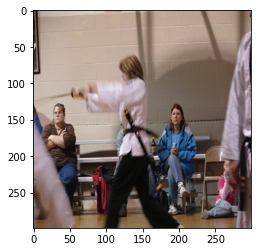

In [108]:
# Training image test-1
idx = 10
t = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(X_train[X_train.keys()[idx]]))
image_decoder(t)

You should also be able to apply the model to dev images and get reasonable captions:

['<START>', 'a', 'climber', 'climbing', 'a', 'rock', 'cliff', '.', '<END>']

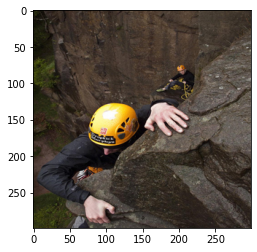

In [49]:
# Testing dev image 1
idx = 26
t = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(X_test[X_test.keys()[idx]]))
image_decoder(t)

## Part VII Beam search (10 pts)

**TODO**: Use beam search algorithm to refine the output captions.

Reference: https://keras.io/api/keras_nlp/utils/beam_search/

https://keras.io/examples/nlp/text_generation_gpt/

In [105]:
def beam_search_predictions(image, beam_index = 3):
    start = [word_to_id["<START>"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < MAX_LEN:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=MAX_LEN, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])   
        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:]
    start_word = start_word[-1][0]
    intermediate_caption = [id_to_word[i] for i in start_word]
    final_caption = []
    for i in intermediate_caption:
        if i != '<END>':
            final_caption.append(i)
        else:
            break
    final_caption = ' '.join(final_caption[1:])
    return final_caption

'a little boy in a red and white shirt is running in a field .'

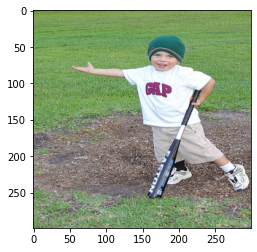

In [106]:
idx = 50
plt.imshow(read_image(X_test[X_test.keys()[idx]]))
beam_search_predictions(np.array(enc_test[idx]).reshape(1,2048))

**TODO**: Randomly plot 10 images with captions from train set and test set each.

Train Set:
-----------------------------------------------


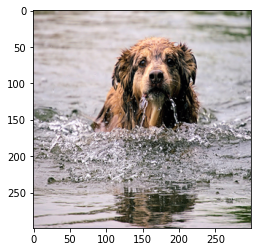

Greedy Search: a dog is running through water .
Beam Search: a brown dog is playing with a ball in the water .



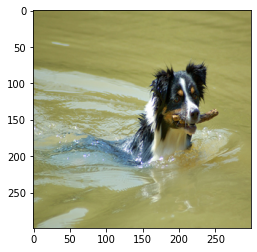

Greedy Search: a dog is running through water .
Beam Search: a brown dog is running through the water .



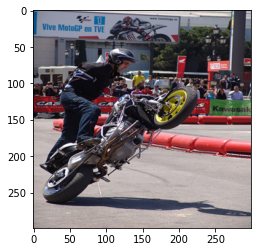

Greedy Search: a man in a yellow suit is riding a motorcycle on a yellow motorcycle .
Beam Search: a group of people run through mud .



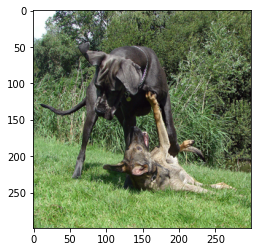

Greedy Search: a dog runs through the grass .
Beam Search: a brown dog with a stick in its mouth runs through the grass .



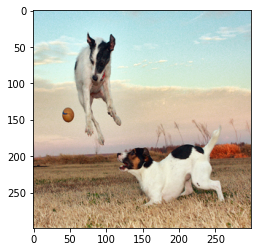

Greedy Search: a white dog is running in a field .
Beam Search: a black and white dog is playing with a red ball .



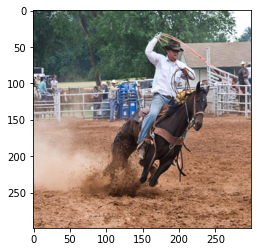

Greedy Search: a group of men in red are racing around a ball .
Beam Search: a group of young men racing around a track .



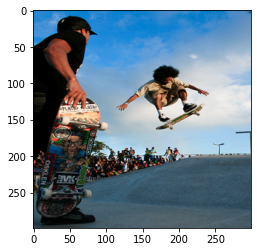

Greedy Search: a man in a red shirt is riding a bike in a field .
Beam Search: a boy in a red and white red and white shirt rides a bike .



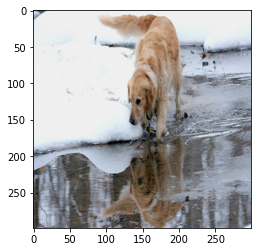

Greedy Search: a dog is running through the water .
Beam Search: a brown dog is playing with a ball in the water .



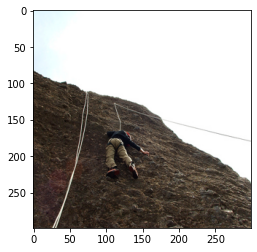

Greedy Search: a man climbs up a rock .
Beam Search: a rock climber climbs up a cliff .



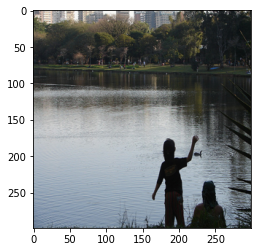

Greedy Search: a man is climbing up a rock face .
Beam Search: a group of people stand in front of a lake .






Test Set:
-----------------------------------------------


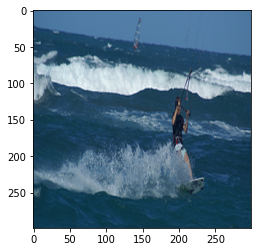

Greedy Search: a man in a yellow kayak is kayaking through the water .
Beam Search: a man in a boat on the water .



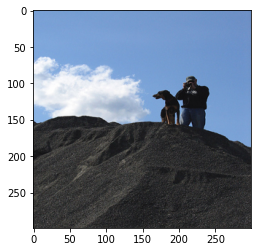

Greedy Search: a person climbs up a rock .
Beam Search: a rock climber climbs up a mountain .



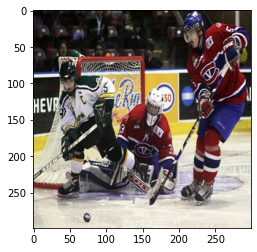

Greedy Search: a hockey player in red is ice during a hockey hockey game .
Beam Search: a team of ice ice ice .



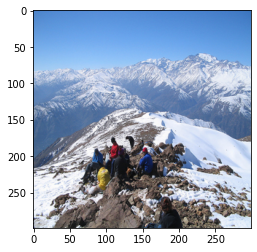

Greedy Search: a person climbs up a mountain .
Beam Search: a rock climber mountains in the mountains .



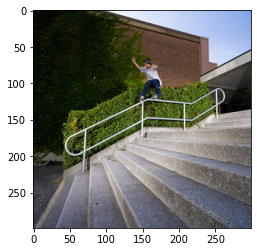

Greedy Search: a skateboarder is skateboarding .
Beam Search: a skateboarder is skateboarding .



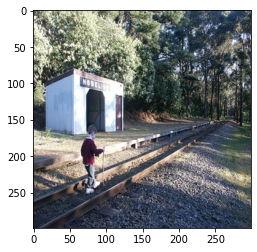

Greedy Search: a man in a red shirt is skateboarding on a skateboard .
Beam Search: a man on a skateboard does a tennis ball .



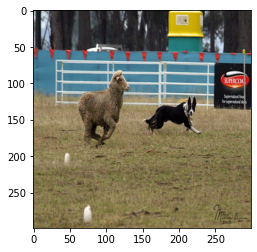

Greedy Search: a white dog is running through a field .
Beam Search: a black and white dog playing with a ball .



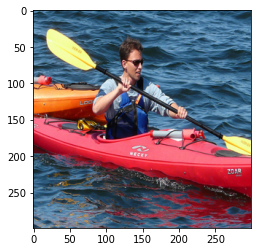

Greedy Search: a boat is boat in a boat .
Beam Search: a boat on a boat .



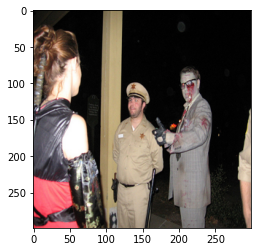

Greedy Search: a man in a white shirt is standing in front of a large white dog .
Beam Search: a little girl in a red and white dress is standing in front of a building .



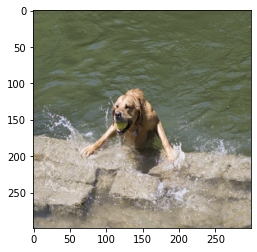

Greedy Search: a dog is running through a field .
Beam Search: a large brown dog is playing with a ball in the water .



In [107]:
print("Train Set:")
print("-----------------------------------------------")
for i in range(10):
  idx = random.randint(0, len(enc_train) - 1)
  plt.imshow(read_image(X_train[X_train.keys()[idx]]))
  plt.show()
  print("Greedy Search: " + " ".join(image_decoder(np.array(enc_train[idx]).reshape(1,2048))[1:-1]))
  print("Beam Search: " + beam_search_predictions(np.array(enc_train[idx]).reshape(1,2048), beam_index = 10))
  print()
print("\n\n\n\n")
print("Test Set:")
print("-----------------------------------------------")
for i in range(10):
  idx = random.randint(0, len(enc_test) - 1)
  plt.imshow(read_image(X_test[X_test.keys()[idx]]))
  plt.show()
  print("Greedy Search: " + " ".join(image_decoder(np.array(enc_test[idx]).reshape(1,2048))[1:-1]))
  print("Beam Search: " + beam_search_predictions(np.array(enc_test[idx]).reshape(1,2048), beam_index = 10))
  print()